In [1]:
# %%
import os, sys, importlib, time, json
import numpy as np
import torch

print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.version.cuda)
print("GPU   :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

# 프로젝트 루트가 현재가 아니라면 아래처럼 경로 추가
# sys.path.append("/path/to/your/project")


Python: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 17:29:18) [GCC 11.2.0]
Torch : 2.6.0+cu124
CUDA  : 12.4
GPU   : Quadro RTX 5000


In [2]:
# %%
# --- 수정 포인트: 데이터 루트 ---
SLSIM_LENSES_DIR      = "/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses"
SLSIM_NONLENSES_DIR   = "/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses"
HSC_DEG_LENSES_DIR    = "/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses"
HSC_DEG_NONLENSES_DIR = "/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses"

CLASS_PATHS = {
    "slsim_lenses": SLSIM_LENSES_DIR,
    "slsim_nonlenses": SLSIM_NONLENSES_DIR,
    "hsc_lenses": HSC_DEG_LENSES_DIR,
    "hsc_nonlenses": HSC_DEG_NONLENSES_DIR,
}


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH  = 256
NUM_WORKERS = 8
SEED   = 42

# 작은 split로 빠르게 디버그
SPLIT = (0.70, 0.15, 0.15)
TAKE_TRAIN_FRAC = 0.002  # train의 0.2%만 사용(속도용), 필요시 None
CLIP_Q = 99.9            # 상위quantile 클리핑(선택)


In [3]:
# 0) 패키지 세팅
from pathlib import Path
import sys, importlib

PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

# 2) 올바른 임포트 (패키지 경로 사용)
import utils as utils
import model as model
import data_loader as data_loader

importlib.reload(utils)
importlib.reload(model)
importlib.reload(data_loader)

from src.model import convnextv2_atto, convnextv2_nano, convnextv2_tiny
from src.data_loader import get_dataloaders, LensFITSBinaryDataset

print("✅ imports via 'src.*' ready")


/home/users/mmingyeong/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ imports via 'src.*' ready


2025-09-05 15:31:04,871 [INFO] [data_loader] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 15:31:05,867 [INFO] [data_loader] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 15:31:06,834 [INFO] [data_loader] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 15:31:07,796 [INFO] [data_loader] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 15:31:07,797 [INFO] [data_loader] TOTAL files collected: 999998
2025-09-05 15:31:07,850 [INFO] [data_loader] Dataset: N=999998 | lens=499999 | nonlens=499999 | augment=False | padding=False(out=41) | normalization=False | clip_q=0.997 | smoothing=none
2025-09-05 15:31:07,887 [INFO] [data_loader] Dataset: N

[FILE] /caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses/D1_L_00000000_g.fits
 RAW:  shape= (41, 41) min=-0.186, max=2.5, mean=0.114, std=0.285
 PAD:  shape= (64, 64) min=-0.186, max=2.5, mean=0.047, std=0.191
 NORM: shape= (41, 41) min=-1.07, max=6.92, mean=0, std=1
 BOTH: shape= (64, 64) min=-1.07, max=6.92, mean=1.02e-08, std=0.641
Saved figure to preproc_compare.png


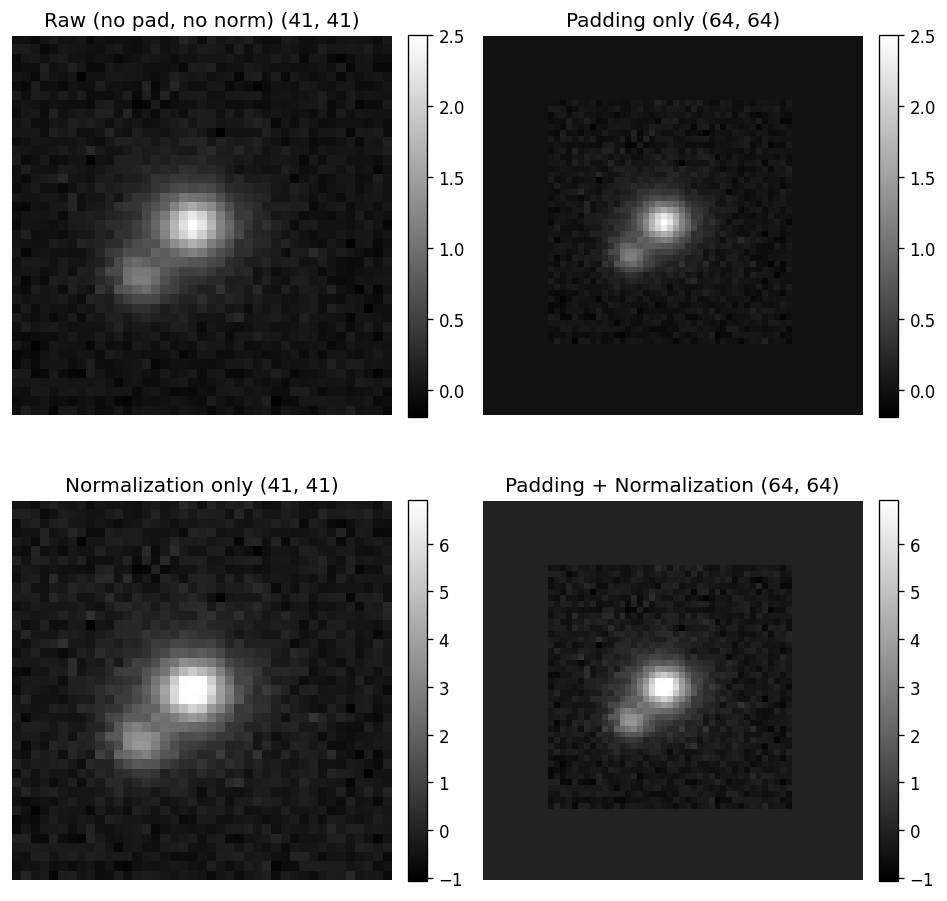

In [4]:
# viz_preprocessing.py
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import torch

from data_loader import (
    LensFITSBinaryDataset,
    collect_files,
)

# ==== 경로를 환경에 맞게 수정하세요 ====
PATHS = {
    "slsim_lenses":     "/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses",
    "slsim_nonlenses":  "/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses",
    "hsc_lenses":       "/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses",
    "hsc_nonlenses":    "/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses",
}

def find_first_valid_index(ds, max_trials=10000):
    """__getitem__이 None이 아닌 첫 번째 인덱스 반환."""
    n = len(ds)
    for i in range(min(n, max_trials)):
        sample = ds[i]
        if sample is not None:
            return i
    raise RuntimeError("No valid sample found in the first {} items".format(max_trials))

def tensor_to_np_img(x):
    """(1,H,W) 또는 (H,W) 텐서를 2D numpy로 변환"""
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    return x.detach().cpu().numpy()

def main():
    files, labels, domains = collect_files(PATHS)
    assert len(files) > 0, "No FITS files found. Please check PATHS."

    # 공통 하이퍼파라미터(원한다면 조정)
    COMMON_KW = dict(
        augment=False,
        clip_q=0.997,
        low_clip_q=None,
        use_mad=False,
    )

    # 4가지 설정의 Dataset을 동일한 files로 구성
    ds_raw   = LensFITSBinaryDataset(files, labels, domains,
                                     apply_padding=False,
                                     apply_normalization=False,
                                     **COMMON_KW)

    ds_pad   = LensFITSBinaryDataset(files, labels, domains,
                                     apply_padding=True,  # 41->64 reflect pad
                                     out_size_when_padded=64,
                                     apply_normalization=False,
                                     **COMMON_KW)

    ds_norm  = LensFITSBinaryDataset(files, labels, domains,
                                     apply_padding=False,
                                     apply_normalization=True,  # bkg-sub + clip + z-score
                                     **COMMON_KW)

    ds_both  = LensFITSBinaryDataset(files, labels, domains,
                                     apply_padding=True,
                                     out_size_when_padded=64,
                                     apply_normalization=True,
                                     **COMMON_KW)

    # 동일한 유효 샘플 인덱스 선택
    idx = find_first_valid_index(ds_raw)
    (x_raw,  y, meta_raw)  = ds_raw[idx]
    (x_pad,  _, meta_pad)  = ds_pad[idx]
    (x_norm, _, meta_norm) = ds_norm[idx]
    (x_both, _, meta_both) = ds_both[idx]

    # 동일 파일을 대상으로 했는지 확인(안전 체크)
    paths = [meta_raw["path"], meta_pad["path"], meta_norm["path"], meta_both["path"]]
    assert len(set(paths)) == 1, "Different files selected; something went wrong."

    # numpy 변환
    im_raw  = tensor_to_np_img(x_raw)   # (H,W)
    im_pad  = tensor_to_np_img(x_pad)
    im_norm = tensor_to_np_img(x_norm)
    im_both = tensor_to_np_img(x_both)

    # 간단한 통계 출력
    def stats(a): 
        return f"min={a.min():.3g}, max={a.max():.3g}, mean={a.mean():.3g}, std={a.std():.3g}"

    print("[FILE]", meta_raw["path"])
    print(" RAW:  shape=", im_raw.shape,  stats(im_raw))
    print(" PAD:  shape=", im_pad.shape,  stats(im_pad))
    print(" NORM: shape=", im_norm.shape, stats(im_norm))
    print(" BOTH: shape=", im_both.shape, stats(im_both))

    # 2x2 시각화
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=120)
    ax = axes.ravel()

    im0 = ax[0].imshow(im_raw, cmap="gray")
    ax[0].set_title(f"Raw (no pad, no norm) {im_raw.shape}")
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(im_pad, cmap="gray")
    ax[1].set_title(f"Padding only {im_pad.shape}")
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(im_norm, cmap="gray")
    ax[2].set_title(f"Normalization only {im_norm.shape}")
    fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    im3 = ax[3].imshow(im_both, cmap="gray")
    ax[3].set_title(f"Padding + Normalization {im_both.shape}")
    fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

    for a in ax:
        a.axis("off")

    plt.tight_layout()
    plt.savefig("preproc_compare.png", bbox_inches="tight")
    print("Saved figure to preproc_compare.png")
    plt.show()

if __name__ == "__main__":
    main()


2025-09-05 15:35:07,147 [INFO] [data_loader] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 15:35:07,787 [INFO] [data_loader] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 15:35:08,436 [INFO] [data_loader] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 15:35:09,067 [INFO] [data_loader] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 15:35:09,068 [INFO] [data_loader] TOTAL files collected: 999998
2025-09-05 15:35:09,949 [INFO] [data_loader] Test subsampling: kept 150/150001 (0.10%)
2025-09-05 15:35:09,979 [INFO] [data_loader] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=False(out=41) | normalization=True |

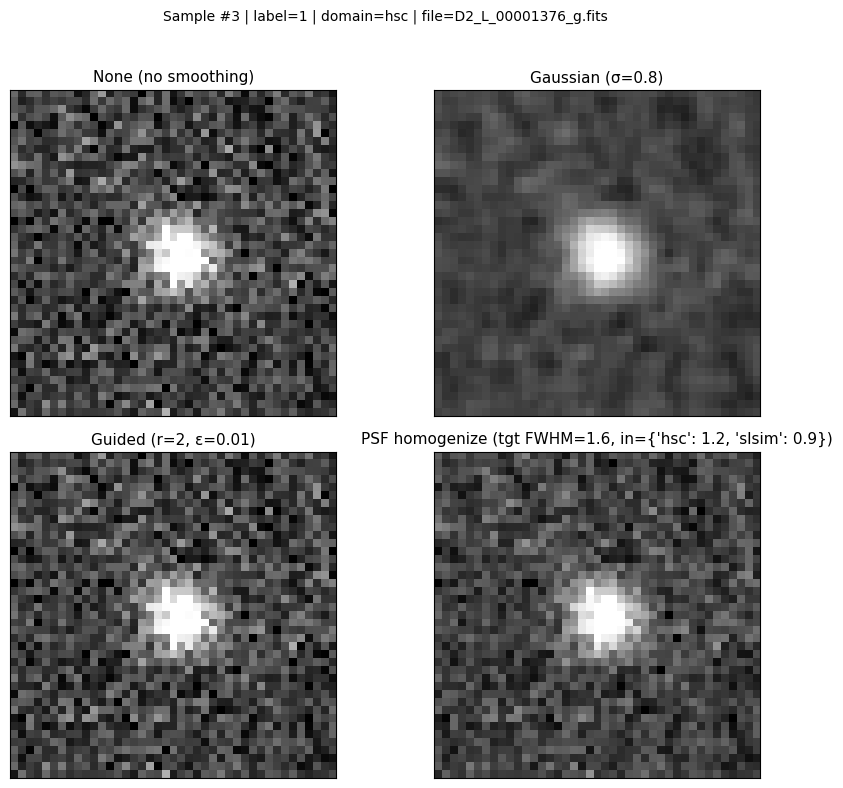

In [8]:
# %% [viz_smoothing_4modes.py]
import sys, types, json, math
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 프로젝트/소스 경로
# -----------------------
PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

from data_loader import get_dataloaders, LensFITSBinaryDataset

# -----------------------
# 데이터 루트 (필요시 수정)
# -----------------------
SLSIM_LENSES_DIR      = "/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses"
SLSIM_NONLENSES_DIR   = "/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses"
HSC_DEG_LENSES_DIR    = "/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses"
HSC_DEG_NONLENSES_DIR = "/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses"

CLASS_PATHS = {
    "slsim_lenses":    SLSIM_LENSES_DIR,
    "slsim_nonlenses": SLSIM_NONLENSES_DIR,
    "hsc_lenses":      HSC_DEG_LENSES_DIR,
    "hsc_nonlenses":   HSC_DEG_NONLENSES_DIR,
}

# -----------------------
# 공통 하이퍼 (정규화/패딩)
# -----------------------
APPLY_NORMALIZATION = True
CLIP_Q = 0.997         # None으로 두면 클리핑 비활성화
LOW_CLIP_Q = None
USE_MAD = False

APPLY_PADDING = False
OUT_SIZE = 64

# -----------------------
# 스무딩 모드별 하이퍼
# -----------------------
GAUSSIAN_SIGMA = 0.8

GUIDED_RADIUS = 2
GUIDED_EPS    = 1e-2

# PSF 균질화: 단위=픽셀(41x41 격자 기준)
# 실제 추정치로 교체 권장
PSF_TARGET_FWHM = 1.6
PSF_INPUT_FWHM_BY_DOMAIN = {"hsc": 1.2, "slsim": 0.9}

# -----------------------
# 먼저 'none'으로 dataloader 만들고,
# 같은 test 파일 리스트를 재사용해
# 네 가지 모드의 Dataset을 구성
# -----------------------
_, _, test_loader_none = get_dataloaders(
    class_paths=CLASS_PATHS,
    batch_size=32,
    split=(0.70, 0.15, 0.15),
    seed=42,
    num_workers=2,
    pin_memory=True,
    augment_train=False,
    take_test_fraction=0.001,     # 빠른 시각화를 위해 아주 소량만 로드 (원하면 None)
    # 공통 전처리
    apply_padding=APPLY_PADDING,
    out_size_when_padded=OUT_SIZE,
    apply_normalization=APPLY_NORMALIZATION,
    clip_q=CLIP_Q,
    low_clip_q=LOW_CLIP_Q,
    use_mad=USE_MAD,
    # 스무딩: none
    smoothing_mode="none",
)

# 동일 test 파일/라벨/도메인 목록 확보
base_ds = test_loader_none.dataset
files, labels, domains = base_ds.files, base_ds.labels, base_ds.domains

# 네 가지 모드의 Dataset 구성 (동일 파일 세트)
def make_ds(smoothing_mode: str):
    return LensFITSBinaryDataset(
        files=files,
        labels=labels,
        domains=domains,
        augment=False,
        # 공통 전처리
        apply_padding=APPLY_PADDING,
        out_size_when_padded=OUT_SIZE,
        apply_normalization=APPLY_NORMALIZATION,
        clip_q=CLIP_Q,
        low_clip_q=LOW_CLIP_Q,
        use_mad=USE_MAD,
        # 스무딩 설정
        smoothing_mode=smoothing_mode,
        gaussian_sigma=GAUSSIAN_SIGMA,
        guided_radius=GUIDED_RADIUS,
        guided_eps=GUIDED_EPS,
        psf_target_fwhm=PSF_TARGET_FWHM,
        psf_input_fwhm_by_domain=PSF_INPUT_FWHM_BY_DOMAIN,
    )

ds_none   = make_ds("none")
ds_gauss  = make_ds("gaussian")
ds_guided = make_ds("guided")
ds_psf    = make_ds("psf")

# -----------------------
# 같은 샘플 인덱스 선택
# (라벨=1(렌즈) 선호 시 필터링 가능)
# -----------------------
idx = 0
# 렌즈 예시 원하면 아래 주석 해제
for i, y in enumerate(labels):
    if y == 1:
        idx = i
        break

samples = {}
for name, ds in [("none", ds_none), ("gaussian", ds_gauss), ("guided", ds_guided), ("psf", ds_psf)]:
    x, y, meta = ds[idx]   # x: (1,H,W)
    samples[name] = (x[0].cpu().numpy(), y, meta)

# 공통 표시 구간(동일 컬러스케일) - 모든 모드 픽셀 모아 퍼센타일로 산정
all_pixels = np.concatenate([s[0].ravel() for s in samples.values()])
vmin = np.percentile(all_pixels, 1.0)
vmax = np.percentile(all_pixels, 99.0)

# -----------------------
# 시각화
# -----------------------
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
modes = [("none", "None (no smoothing)"),
         ("gaussian", f"Gaussian (σ={GAUSSIAN_SIGMA})"),
         ("guided",   f"Guided (r={GUIDED_RADIUS}, ε={GUIDED_EPS})"),
         ("psf",      f"PSF homogenize (tgt FWHM={PSF_TARGET_FWHM}, in={PSF_INPUT_FWHM_BY_DOMAIN})")]

for ax, (key, title) in zip(axes.ravel(), modes):
    img, y, meta = samples[key]
    ax.imshow(img, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=11)
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle(f"Sample #{idx} | label={samples['none'][1]} | domain={samples['none'][2]['domain']} | file={Path(samples['none'][2]['path']).name}", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
